<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/MADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

Cloning into 'nn_hallucinations'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 72 (delta 35), reused 22 (delta 9), pack-reused 0
Unpacking objects: 100% (72/72), done.


In [0]:
import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
import numpy as np
import torch
from torch import distributions 
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils import data
import torchvision
from torchvision import transforms
from torchvision import datasets

In [4]:
BATCH_SIZE = 512
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.view(-1),  # Flatten.
    lambda x: distributions.Bernoulli(probs=x).sample()])

train_loader = data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=TRANSFORM),
    batch_size=BATCH_SIZE, 
    shuffle=True)
test_loader = data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,transform=TRANSFORM),
    batch_size=BATCH_SIZE*2)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class MaskedLinear(nn.Linear):
  def __init__(self, in_features, out_features, bias=True):
    super().__init__(in_features, out_features, bias)
    self.register_buffer('mask', torch.ones((out_features, in_features)))

  def set_mask(self, mask):
    self.mask.data.copy_(mask)

  def forward(self, x):
    return F.linear(x, self.weight * self.mask, self.bias)


class MADE(nn.Module):
  """TODO

  Natural Ordering.
  
  This implementation only samples the hidden units and does not sample masks
  for the inputs/outputs. The mask sampling MADE can still be supported 
  externally.
  """

  def __init__(self, input_dim, hidden_dims=None):
    """TODO."""
    super().__init__()
    self._dims = [input_dim] + (hidden_dims or []) + [input_dim]
    layers = []
    for i in range(len(self._dims) - 1):
      in_dim, out_dim = self._dims[i], self._dims[i + 1]
      layers.append(MaskedLinear(in_dim, out_dim))
      layers.append(nn.ReLU())
    layers[-1] = nn.Sigmoid()
    self._net = nn.Sequential(*layers)

  def _sample_masks(self):
    input_dim, output_dim = self._dims[0], self._dims[-1]

    # Sample connectivity patterns.
    conn = [np.arange(input_dim)]
    for i, dim in enumerate(self._dims[1:-1]):
      # NOTE(eugenhotaj): The dimensions in the paper are 1-indexed whereas 
      # arrays in Python are 0-indexed. Implementation adjusted accordingly. 
      low = 0 if i == 0 else np.min(masks[i - 1])
      high = input_dim - 1
      conn.append(np.random.randint(low, high, size=dim))
    conn.append(np.arange(output_dim))

    # Create masks.
    masks = [conn[i - 1][None, :] <= conn[i][:, None] 
             for i in range(1, len(conn) - 1 )]
    masks.append(conn[-2][None, :] < conn[i][:, None])

    return [torch.from_numpy(mask) for mask in masks]

  def forward(self, x):
    """Computes a forward pass."""
    layers = [
      layer for layer in self._net.modules() if isinstance(layer, MaskedLinear)]
    masks = self._sample_masks()
    for layer, mask in zip(layers, masks):
      layer.set_mask(mask)
    return self._net(x)

In [116]:
INPUT_SIZE = 784
HIDDEN_SIZES = [8000]
N_EPOCHS = 50

model = MADE(INPUT_SIZE, HIDDEN_SIZES).to(colab_utils.get_device())
optimizer = optim.Adam(model.parameters())
bce_loss_fn = nn.BCELoss(reduction='none')
loss_fn = lambda x, y, preds: bce_loss_fn(preds, x).sum(dim=1).mean()

train_losses, eval_losses = colab_utils.train_andor_evaluate(
    model, 
    loss_fn, 
    optimizer=optimizer, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader,
    eval_loader=test_loader,
    device=colab_utils.get_device())

[1]: train_loss=274.40914889322914 eval_loss=206.51468452148438
[2]: train_loss=190.15902924804686 eval_loss=176.92959228515625
[3]: train_loss=172.54043540039063 eval_loss=168.460084375
[4]: train_loss=164.23812001953124 eval_loss=160.59580803222656
[5]: train_loss=159.00201850585938 eval_loss=157.17939724121095
[6]: train_loss=155.04233505859375 eval_loss=152.47693684082031
[7]: train_loss=151.85314050292968 eval_loss=150.11135710449219
[8]: train_loss=149.51234130859376 eval_loss=147.10324306640624
[9]: train_loss=147.64969795735678 eval_loss=146.04054833984375
[10]: train_loss=145.8311455078125 eval_loss=144.7300384765625
[11]: train_loss=144.62910268554688 eval_loss=145.1135419921875
[12]: train_loss=143.46134317220051 eval_loss=142.59646228027344
[13]: train_loss=142.69692510579426 eval_loss=141.5394405029297
[14]: train_loss=141.58371896158854 eval_loss=141.09372338867186
[15]: train_loss=140.37854650065105 eval_loss=141.01697133789062
[16]: train_loss=139.95205690104166 eval_lo

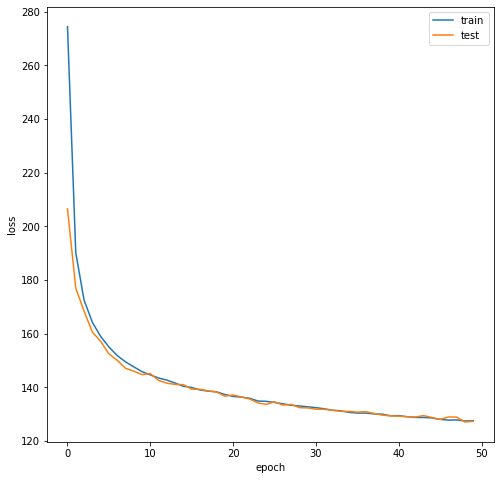

In [119]:
epochs = len(train_losses)
plt.figure(figsize=(8, 8))
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), eval_losses)
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
def show_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img_hat = model(img)
  colab_utils.imshow(img.reshape(28, 28))
  colab_utils.imshow(img_hat.reshape(28, 28))


def sample(model):
  colab_utils.imshow(model.sample().reshape(28, 28))


def conditional_sample_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img[0, 300:600] = -1
  colab_utils.imshow(img.reshape(28, 28))
  plt.show()
  print("Conditional Samples:")
  for i in range(5):
    img_hat = model.sample(img)
    colab_utils.imshow(img_hat.reshape(28, 28))

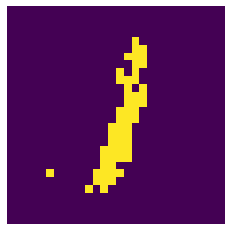

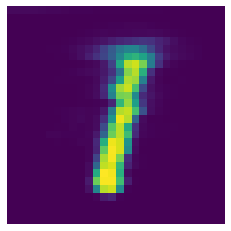

In [125]:
show_random(model, test_loader.dataset)